# TESTANDO MODELOS

In [110]:
# %pip install feature-engine

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [112]:
# FUNÇÃO PARA IDENTIFICAR PARES DE VARIÁVEIS COM ALTA CORRELAÇÃO

def identify_correlated_pairs(df, threshold=0.75):
    """
    Identifica pares de colunas com correlação alta em um DataFrame.
    
    Parâmetros:
    df (pd.DataFrame): DataFrame com as variáveis a serem analisadas.
    threshold (float): Valor de correlação mínima para considerar como alta.

    Retorna:
    list: Lista de tuplas com colunas e seus valores de correlação.
    """
    corr_matrix = df.corr().abs()
    
    # Obter os índices de correlações altas, exceto a diagonal principal
    high_corr_pairs = np.where((corr_matrix > threshold) & 
                               (np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)))
    
    # Obter os pares de colunas com correlação > threshold
    high_corr_list = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y]) 
                      for x, y in zip(*high_corr_pairs)]
    
    return high_corr_list


In [113]:
# FUNÇÃO PARA TESTAR MODELOS SEM BALANCEAMENTO DE CLASSES

def evaluate_models(X_train, y_train, X_test, y_test):    
    from sklearn.model_selection import cross_val_score, StratifiedKFold
    from sklearn.ensemble import RandomForestClassifier
    from xgboost import XGBClassifier
    from catboost import CatBoostClassifier
    from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
    import pandas as pd
    
    # Separando dados em folds
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Criando os modelos
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=30, min_samples_split=5),
        'XGBoost': XGBClassifier(learning_rate=0.2, max_depth=6, n_estimators=200, eval_metric='logloss'),
        'CatBoost': CatBoostClassifier(depth=8, iterations=200, l2_leaf_reg=2, learning_rate=0.2, loss_function='MultiClass', silent=True)
    }

    # Criar uma lista para armazenar os resultados
    results = []

    # Avaliando e treinando cada modelo
    for model_name, model in models.items():
        print(f"Avaliando modelo: {model_name}")

        # Avaliando o modelo com validação cruzada
        scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
        acuracia_treino = scores.mean()
        print("Scores de validação cruzada:", scores)
        print("Acurácia média de treino:", acuracia_treino)

        # Treinando o modelo e fazendo previsões
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Avaliar o modelo e coletar métricas
        report = classification_report(y_test, y_pred, output_dict=True)
        accuracy_teste = accuracy_score(y_test, y_pred)

        # Medição do Desempenho ROC_AUC_SCORE para múltiplas classes (One-vs-Rest)
        predicoes = model.predict_proba(X_test)
        roc_auc_score_test = roc_auc_score(y_test, predicoes, multi_class='ovr')

        # Adicionar as métricas ao DataFrame
        for class_label in report.keys():
            if class_label not in ['accuracy', 'macro avg', 'weighted avg']:
                results.append({
                    'Modelo': model_name,
                    'Acurácia do Treino': acuracia_treino,
                    'Acurácia do Teste': accuracy_teste,
                    'ROC_AUC_SCORE': roc_auc_score_test,
                    'Classe': class_label,
                    'F1 Score': report[class_label]['f1-score'],
                    'Precisão': report[class_label]['precision'],
                    'Recall': report[class_label]['recall']
                })

        print("Relatório de classificação:")
        print(classification_report(y_test, y_pred))
        print("Acurácia do Teste:", accuracy_teste)
        print("Desempenho ROC/AUC:", roc_auc_score_test)
        print("-" * 50)  # Separador entre os modelos

    # Criar um DataFrame com os resultados
    results_df = pd.DataFrame(results)
    return results_df

In [114]:
# FUNÇÃO PARA TESTAR MODELOS SEM BALANCEAMENTO DE CLASSES

def evaluate_models_with_smote(X_train, y_train, X_test, y_test):
    from sklearn.model_selection import cross_val_score, StratifiedKFold
    from sklearn.ensemble import RandomForestClassifier
    from xgboost import XGBClassifier
    from catboost import CatBoostClassifier
    from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
    from imblearn.over_sampling import SMOTE
    import pandas as pd
    # Separando dados em folds
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Criando os modelos
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=30, min_samples_split=5, class_weight='balanced'),
        'XGBoost': XGBClassifier(learning_rate=0.2, max_depth=6, n_estimators=200, eval_metric='logloss'),
        'CatBoost': CatBoostClassifier(depth=8, iterations=200, l2_leaf_reg=2, learning_rate=0.2, loss_function='MultiClass', silent=True)
    }

    # Aplicar SMOTE para sobreamostragem da classe minoritária
    smote = SMOTE(random_state=42)

    # Criar uma lista para armazenar os resultados
    results = []

    # Avaliando e treinando cada modelo
    for model_name, model in models.items():
        print(f"Avaliando modelo: {model_name}")
        
        # Aplicar SMOTE nos dados de treinamento
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

        # Avaliando o modelo com validação cruzada
        scores = cross_val_score(model, X_resampled, y_resampled, cv=skf, scoring='accuracy')
        acuracia_treino = scores.mean()
        print("Scores de validação cruzada:", scores)
        print("Acurácia média de treino:", acuracia_treino)

        # Treinando o modelo e fazendo previsões
        model.fit(X_resampled, y_resampled)  # Treinando o modelo com os dados reamostrados
        y_pred = model.predict(X_test)  # Fazendo previsões

        # Avaliar o modelo e coletar métricas
        report = classification_report(y_test, y_pred, output_dict=True)
        accuracy_teste = accuracy_score(y_test, y_pred)

        # Medição do Desempenho ROC_AUC_SCORE
        predicoes = model.predict_proba(X_test)
        roc_auc_score_test = roc_auc_score(y_test, predicoes, multi_class='ovr', average='macro')

        # Adicionar as métricas ao DataFrame
        for class_label in report.keys():
            if class_label not in ['accuracy', 'macro avg', 'weighted avg']:
                results.append({
                    'Modelo': model_name,
                    'Acurácia do Treino': acuracia_treino,
                    'Acurácia do Teste': accuracy_teste,
                    'ROC_AUC_SCORE': roc_auc_score_test,
                    'Classe': class_label,
                    'F1 Score': report[class_label]['f1-score'],
                    'Precisão': report[class_label]['precision'],
                    'Recall': report[class_label]['recall']
                })

        print("Relatório de classificação:")
        print(classification_report(y_test, y_pred))
        print("Acurácia do Teste:", accuracy_teste)
        print("Desempenho ROC/AUC:", roc_auc_score_test)
        print("-" * 50)  # Separador entre os modelos

    # Criar um DataFrame com os resultados
    results_df = pd.DataFrame(results)
    return results_df


In [115]:
# Load the datasets

pd.set_option('display.max_columns', 170)
pd.set_option('display.max_rows', 170)

df = pd.read_csv('bases/df_merge.csv')

df.shape

(96502, 77)

In [116]:
df

,id_familia,classe_renda,uf_ibge,estrato,classf,cod_local_domic_fam,cod_familia_indigena_fam,ind_familia_quilombola_fam,ind_parc_mds_fam,cod_especie_domic_fam,qtd_comodos_domic_fam,qtd_comodos_dormitorio_fam,cod_material_piso_fam,cod_material_domic_fam,cod_agua_canalizada_fam,cod_abaste_agua_domic_fam,cod_banheiro_domic_fam,cod_escoa_sanitario_domic_fam,cod_destino_lixo_domic_fam,cod_iluminacao_domic_fam,cod_calcamento_domic_fam,chefe_mulher,chefe_idoso,chefe_idade<media,chefe_idade>=media,chefe_jovem29,chefe_branco,chefe_preto,chefe_pardo,chefe_indigena,chefe_analfabeto,chefe_nunca_freq_escola,chefe_estudante,chefe_estudante_fundamental,chefe_estudante_medio,chefe_estudante_superior,chefe_escolaridade_fund1,chefe_escolaridade_fund2,chefe_escolaridade_medio,chefe_escolaridade_superior,chefe_nao_trabalhou_semana,chefe_nao_trabalhou_12meses,chefe_conta_propria,chefe_temporario_rural,chefe_empregado_sem_carteira,chefe_empregado_com_carteira,chefe_trab_domestico_sem_carteira,chefe_trab_nao_remunerado,chefe_militar_servidor,qde_pessoas,pct_mulheres,pct_homens,pct_criancas,pct_jovens_entre_15_29,pct_idosos,pct_deficientes,pct_analfabetos>10,pct_jovens_sem_escola,pct_jovens_escola_privada,pct_criancas_creche,pct_fundamental1,pct_fundamental2,pct_ensino_medio,pct_trabalho_semana_adulto,pct_trabalho_semana_idoso,pct_trabalho_semana_crianca,pct_extrativista,pct_conta_propria,pct_trab_rural_temporario,pct_empregado_sem_carteira,pct_empregado_com_carteira,pct_trab_domestico_sem_carteira,pct_trab_nao_remunerado,pct_militar_servidor,pct_trabalho_12meses_adulto,pct_trabalho_12meses_idoso,pct_trabalho_12meses_crianca
0,268503,0.0,42,1,2,1.0,2.0,2.0,0.0,1.0,5.0,2.0,5.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4.0,1.000000,0.000000,0.500000,0.250000,0.0,0.0,0.25,0.0,0.0,0.250000,0.25,0.000000,0.000000,0.250000,0.0,0.0,0.250000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0
1,2888440,0.0,29,2,3,2.0,2.0,2.0,0.0,1.0,2.0,1.0,2.0,2.0,2.0,4.0,1.0,3.0,3.0,1.0,3.0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,2.0,1.000000,0.000000,0.500000,0.500000,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.000000,0.500000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,2113517,2.0,35,2,3,1.0,2.0,2.0,0.0,1.0,5.0,2.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2.0,0.500000,0.500000,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000,0.50,0.000000,0.500000,1.000000,0.0,0.0,0.000000,0.500000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0
3,4419096,0.0,33,2,2,1.0,2.0,2.0,0.0,1.0,3.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,2.0,1.000000,0.000000,0.500000,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.000000,0.500000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,4241219,0.0,28,2,1,1.0,2.0,2.0,0.0,1.0,4.0,1.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1.0,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96497,5181019,0.0,35,2,1,1.0,2.0,2.0,0.0,1.0,2.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,3.0,0.666667,0.333333,0.666667,0.333333,0.0,0.0,0.00,0.0,0.0,0.333333,0.00,0.000000,0.333333,0.333333,0.0,0.0,0.000000,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0
96498,3853705,0.0,23,2,2,1.0,2.0,2.0,0.0,1.0,2.0,1.0,5.0,1.0,1.0,4.0,1.0,3.0,1.0,6.0,3.0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,2.0,1.000000,0.000000

In [117]:
# alterando o nome das colunas

# Supondo que df seja o seu DataFrame
df.rename(columns={'chefe_idade<media': 'chefe_idade_menor_media',
          'chefe_idade>=media': 'chefe_idade_maiorigual_media'}, inplace=True)

# Verificar se a coluna foi renomeada corretamente
print(df.columns)


Index(['id_familia', 'classe_renda', 'uf_ibge', 'estrato', 'classf',
       'cod_local_domic_fam', 'cod_familia_indigena_fam',
       'ind_familia_quilombola_fam', 'ind_parc_mds_fam',
       'cod_especie_domic_fam', 'qtd_comodos_domic_fam',
       'qtd_comodos_dormitorio_fam', 'cod_material_piso_fam',
       'cod_material_domic_fam', 'cod_agua_canalizada_fam',
       'cod_abaste_agua_domic_fam', 'cod_banheiro_domic_fam',
       'cod_escoa_sanitario_domic_fam', 'cod_destino_lixo_domic_fam',
       'cod_iluminacao_domic_fam', 'cod_calcamento_domic_fam', 'chefe_mulher',
       'chefe_idoso', 'chefe_idade_menor_media',
       'chefe_idade_maiorigual_media', 'chefe_jovem29', 'chefe_branco',
       'chefe_preto', 'chefe_pardo', 'chefe_indigena', 'chefe_analfabeto',
       'chefe_nunca_freq_escola', 'chefe_estudante',
       'chefe_estudante_fundamental', 'chefe_estudante_medio',
       'chefe_estudante_superior', 'chefe_escolaridade_fund1',
       'chefe_escolaridade_fund2', 'chefe_escolarid

In [118]:
#Checando os valores únicos das colunas
# Definindo as colunas a serem analisadas

columns_to_check = ['id_familia', 'uf_ibge', 'estrato', 'classf',
       'cod_local_domic_fam', 'cod_familia_indigena_fam',
       'ind_familia_quilombola_fam', 'ind_parc_mds_fam',
       'cod_especie_domic_fam', 'qtd_comodos_domic_fam',
       'qtd_comodos_dormitorio_fam', 'cod_material_piso_fam',
       'cod_material_domic_fam', 'cod_agua_canalizada_fam',
       'cod_abaste_agua_domic_fam', 'cod_banheiro_domic_fam',
       'cod_escoa_sanitario_domic_fam', 'cod_destino_lixo_domic_fam',
       'cod_iluminacao_domic_fam', 'cod_calcamento_domic_fam', 'chefe_mulher',
       'chefe_idoso', 'chefe_idade_menor_media',
       'chefe_idade_maiorigual_media',
       'chefe_jovem29', 'chefe_branco', 'chefe_preto', 'chefe_pardo',
       'chefe_indigena', 'chefe_analfabeto', 'chefe_nunca_freq_escola',
       'chefe_estudante', 'chefe_estudante_fundamental',
       'chefe_estudante_medio', 'chefe_estudante_superior',
       'chefe_escolaridade_fund1', 'chefe_escolaridade_fund2',
       'chefe_escolaridade_medio', 'chefe_escolaridade_superior',
       'chefe_nao_trabalhou_semana', 'chefe_nao_trabalhou_12meses',
       'chefe_conta_propria', 'chefe_temporario_rural',
       'chefe_empregado_sem_carteira', 'chefe_empregado_com_carteira',
       'chefe_trab_domestico_sem_carteira', 'chefe_trab_nao_remunerado',
       'chefe_militar_servidor', 'qde_pessoas', 'pct_mulheres', 'pct_homens',
       'pct_criancas', 'pct_jovens_entre_15_29', 'pct_idosos',
       'pct_deficientes', 'pct_analfabetos>10', 'pct_jovens_sem_escola',
       'pct_jovens_escola_privada', 'pct_criancas_creche', 'pct_fundamental1',
       'pct_fundamental2', 'pct_ensino_medio', 'pct_trabalho_semana_adulto',
       'pct_trabalho_semana_idoso', 'pct_trabalho_semana_crianca',
       'pct_extrativista', 'pct_conta_propria', 'pct_trab_rural_temporario',
       'pct_empregado_sem_carteira', 'pct_empregado_com_carteira',
       'pct_trab_domestico_sem_carteira', 'pct_trab_nao_remunerado',
       'pct_militar_servidor', 'pct_trabalho_12meses_adulto',
       'pct_trabalho_12meses_idoso', 'pct_trabalho_12meses_crianca']

# Criando um dicionário para armazenar os tipos de resposta
response_types = {}

# Iterando sobre as colunas e coletando os valores únicos
for column in columns_to_check:
    response_types[column] = df[column].unique()

# Exibindo os tipos de resposta de cada coluna
for column, unique_values in response_types.items():
    print(f"Coluna: {column}\nValores únicos: {unique_values}\n")

Coluna: id_familia
Valores únicos: [ 268503 2888440 2113517 ... 1232994 1330889 1481101]

Coluna: uf_ibge
Valores únicos: [42 29 35 33 28 21 13 41 26 50 17 15 32 22 23 31 43 12 25 24 52 11 27 51
 16 14 53]

Coluna: estrato
Valores únicos: [1 2]

Coluna: classf
Valores únicos: [2 3 1]

Coluna: cod_local_domic_fam
Valores únicos: [1. 2. 9.]

Coluna: cod_familia_indigena_fam
Valores únicos: [2. 1.]

Coluna: ind_familia_quilombola_fam
Valores únicos: [2. 1.]

Coluna: ind_parc_mds_fam
Valores únicos: [  0.   9. 205. 301. 202. 204. 304. 201. 303. 305. 306. 101. 203. 302.]

Coluna: cod_especie_domic_fam
Valores únicos: [1. 2. 3. 9.]

Coluna: qtd_comodos_domic_fam
Valores únicos: [ 5.  2.  3.  4. -1.  8.  6.  7.  9.  1. 10. 11. 12. 13. 15. 14. 16.  0.]

Coluna: qtd_comodos_dormitorio_fam
Valores únicos: [ 2.  1. -1.  3.  4.  5.  0.  6. 15.  7. 11. 10. 12. 20.  8.  9.]

Coluna: cod_material_piso_fam
Valores únicos: [ 5.  2. -1.  4.  1.  3.  7.  6.]

Coluna: cod_material_domic_fam
Valores únicos

In [119]:
# APLICANDO FUNÇÃO PARA IDENTIFICAR COLUNAS COM ALTA CORRELAÇÃO
high_corr_results = identify_correlated_pairs(df)
for col1, col2, corr_value in high_corr_results:
    print(f"Resultado: {col1} e {col2}, Correlação: {corr_value:.2f}")


Resultado: qtd_comodos_domic_fam e qtd_comodos_dormitorio_fam, Correlação: 0.81
Resultado: cod_agua_canalizada_fam e cod_banheiro_domic_fam, Correlação: 0.83
Resultado: chefe_idoso e pct_idosos, Correlação: 0.93
Resultado: chefe_idade_menor_media e chefe_idade_maiorigual_media, Correlação: 1.00
Resultado: chefe_branco e chefe_indigena, Correlação: 0.79
Resultado: chefe_analfabeto e chefe_nunca_freq_escola, Correlação: 0.76
Resultado: chefe_analfabeto e pct_analfabetos>10, Correlação: 0.84
Resultado: chefe_escolaridade_fund1 e pct_fundamental1, Correlação: 0.82
Resultado: chefe_escolaridade_medio e pct_ensino_medio, Correlação: 0.78
Resultado: chefe_nao_trabalhou_semana e chefe_nao_trabalhou_12meses, Correlação: 1.00
Resultado: chefe_conta_propria e pct_conta_propria, Correlação: 0.75
Resultado: chefe_temporario_rural e pct_trab_rural_temporario, Correlação: 0.78
Resultado: chefe_empregado_sem_carteira e pct_empregado_sem_carteira, Correlação: 0.77
Resultado: chefe_empregado_com_carteir

In [120]:
# deletando colunas com alta correlação

print(f'Shape antes: {df.shape}')

cols_to_delete = ['qtd_comodos_dormitorio_fam', 
                  'cod_banheiro_domic_fam',
                  'chefe_idoso',
                  'chefe_idade_maiorigual_media', 
                  'chefe_branco',
                  'chefe_nunca_freq_escola',
                  'chefe_analfabeto',
                  'chefe_escolaridade_fund1',
                  'chefe_escolaridade_medio',
                  'chefe_nao_trabalhou_semana',
                  'chefe_conta_propria',
                  'chefe_temporario_rural',
                  'chefe_empregado_sem_carteira',
                  'chefe_empregado_com_carteira',
                  'chefe_trab_domestico_sem_carteira',
                  'chefe_trab_nao_remunerado',
                  'chefe_militar_servidor',
                  'pct_homens',
                  'pct_trabalho_semana_adulto',
                  'pct_trabalho_semana_idoso',
                  'pct_trabalho_semana_crianca']


# Deletando as colunas
df = df.drop(columns=cols_to_delete)

print(f'Shape depois: {df.shape}')

df


Shape antes: (96502, 77)
Shape depois: (96502, 56)


,id_familia,classe_renda,uf_ibge,estrato,classf,cod_local_domic_fam,cod_familia_indigena_fam,ind_familia_quilombola_fam,ind_parc_mds_fam,cod_especie_domic_fam,qtd_comodos_domic_fam,cod_material_piso_fam,cod_material_domic_fam,cod_agua_canalizada_fam,cod_abaste_agua_domic_fam,cod_escoa_sanitario_domic_fam,cod_destino_lixo_domic_fam,cod_iluminacao_domic_fam,cod_calcamento_domic_fam,chefe_mulher,chefe_idade_menor_media,chefe_jovem29,chefe_preto,chefe_pardo,chefe_indigena,chefe_estudante,chefe_estudante_fundamental,chefe_estudante_medio,chefe_estudante_superior,chefe_escolaridade_fund2,chefe_escolaridade_superior,chefe_nao_trabalhou_12meses,qde_pessoas,pct_mulheres,pct_criancas,pct_jovens_entre_15_29,pct_idosos,pct_deficientes,pct_analfabetos>10,pct_jovens_sem_escola,pct_jovens_escola_privada,pct_criancas_creche,pct_fundamental1,pct_fundamental2,pct_ensino_medio,pct_extrativista,pct_conta_propria,pct_trab_rural_temporario,pct_empregado_sem_carteira,pct_empregado_com_carteira,pct_trab_domestico_sem_carteira,pct_trab_nao_remunerado,pct_militar_servidor,pct_trabalho_12meses_adulto,pct_trabalho_12meses_idoso,pct_trabalho_12meses_crianca
0,268503,0.0,42,1,2,1.0,2.0,2.0,0.0,1.0,5.0,5.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1,1,0,0,0,0,0,0,0,0,0,0,0,4.0,1.000000,0.500000,0.250000,0.0,0.0,0.25,0.0,0.0,0.250000,0.25,0.000000,0.000000,0.250000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0
1,2888440,0.0,29,2,3,2.0,2.0,2.0,0.0,1.0,2.0,2.0,2.0,2.0,4.0,3.0,3.0,1.0,3.0,1,1,1,0,0,1,0,0,0,0,0,0,1,2.0,1.000000,0.500000,0.500000,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.000000,0.500000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,2113517,2.0,35,2,3,1.0,2.0,2.0,0.0,1.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,0,0,0,0,1,0,0,0,0,0,0,0,2.0,0.500000,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000,0.50,0.000000,0.500000,0.000000,0.500000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0
3,4419096,0.0,33,2,2,1.0,2.0,2.0,0.0,1.0,3.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,1,0,0,0,0,0,0,0,0,0,0,1,2.0,1.000000,0.500000,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.000000,0.500000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,4241219,0.0,28,2,1,1.0,2.0,2.0,0.0,1.0,4.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1,0,0,0,0,1,0,0,0,0,1,0,1,1.0,1.000000,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96497,5181019,0.0,35,2,1,1.0,2.0,2.0,0.0,1.0,2.0,5.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,1,1,1,0,0,0,0,0,0,0,0,0,0,3.0,0.666667,0.666667,0.333333,0.0,0.0,0.00,0.0,0.0,0.333333,0.00,0.000000,0.333333,0.000000,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0
96498,3853705,0.0,23,2,2,1.0,2.0,2.0,0.0,1.0,2.0,5.0,1.0,1.0,4.0,3.0,1.0,6.0,3.0,1,1,1,0,0,1,0,0,0,0,1,0,1,2.0,1.000000,0.500000,0.500000,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.500000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
96499,1232994,2.0,29,1,3,1.0,2.0,2.0,0.0,1.0,6.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0,0,1,0,0,0,0,0,0,1,2.0,0.500000,0.000000,0.000000,1.0,0.0,0.50,0.0,0.0,0.000000,0.50,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
96500,1330889,0.0,31,1,3,1.0,2.0,2.0,0.0,1.0,5.0,5.0,2.0,1.0,1.0,3.0,3.0,1.0,3.0,1,1,0,0,0,1,0,0,0,0,0,0,1,3.0,0.333333,0.333333,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.333333,0.333333,0.333333,0.000000,0.333333,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0


In [121]:
# Verificando se ainda há correlação entre as variáveis

high_corr_results = identify_correlated_pairs(df)
for col1, col2, corr_value in high_corr_results:
    print(f"Resultado: {col1} e {col2}, Correlação: {corr_value:.2f}")

In [122]:
df.columns

Index(['id_familia', 'classe_renda', 'uf_ibge', 'estrato', 'classf',
       'cod_local_domic_fam', 'cod_familia_indigena_fam',
       'ind_familia_quilombola_fam', 'ind_parc_mds_fam',
       'cod_especie_domic_fam', 'qtd_comodos_domic_fam',
       'cod_material_piso_fam', 'cod_material_domic_fam',
       'cod_agua_canalizada_fam', 'cod_abaste_agua_domic_fam',
       'cod_escoa_sanitario_domic_fam', 'cod_destino_lixo_domic_fam',
       'cod_iluminacao_domic_fam', 'cod_calcamento_domic_fam', 'chefe_mulher',
       'chefe_idade_menor_media', 'chefe_jovem29', 'chefe_preto',
       'chefe_pardo', 'chefe_indigena', 'chefe_estudante',
       'chefe_estudante_fundamental', 'chefe_estudante_medio',
       'chefe_estudante_superior', 'chefe_escolaridade_fund2',
       'chefe_escolaridade_superior', 'chefe_nao_trabalhou_12meses',
       'qde_pessoas', 'pct_mulheres', 'pct_criancas', 'pct_jovens_entre_15_29',
       'pct_idosos', 'pct_deficientes', 'pct_analfabetos>10',
       'pct_jovens_sem_esco

In [123]:
# conferindo variáveis

print(df.shape)


id_cols = ['id_familia', 'classe_renda']

binary_cols = ['estrato', 'cod_familia_indigena_fam',
       'ind_familia_quilombola_fam', 'chefe_mulher',
       'chefe_idade_menor_media', 'chefe_jovem29', 'chefe_preto', 'chefe_pardo',
       'chefe_indigena', 'chefe_estudante', 'chefe_estudante_fundamental',
       'chefe_estudante_medio', 'chefe_estudante_superior',
       'chefe_escolaridade_fund2', 'chefe_escolaridade_superior',
       'chefe_nao_trabalhou_12meses']

multiclass_cols = ['uf_ibge', 'classf', 'cod_local_domic_fam', 
       'ind_parc_mds_fam', 'cod_especie_domic_fam',
       'cod_material_piso_fam', 'cod_material_domic_fam', 
       'cod_agua_canalizada_fam', 'cod_abaste_agua_domic_fam', 
       'cod_escoa_sanitario_domic_fam', 'cod_destino_lixo_domic_fam', 
       'cod_iluminacao_domic_fam', 'cod_calcamento_domic_fam'] 

numerical_cols = ['qtd_comodos_domic_fam', 'qde_pessoas'] 

percentage_cols = ['pct_mulheres', 'pct_criancas', 'pct_jovens_entre_15_29', 
       'pct_idosos', 'pct_deficientes', 'pct_analfabetos>10', 
       'pct_jovens_sem_escola', 'pct_jovens_escola_privada', 
       'pct_criancas_creche', 'pct_fundamental1', 
       'pct_fundamental2', 'pct_ensino_medio', 'pct_extrativista',
       'pct_conta_propria', 'pct_trab_rural_temporario',
       'pct_empregado_sem_carteira', 'pct_empregado_com_carteira',
       'pct_trab_domestico_sem_carteira', 'pct_trab_nao_remunerado',
       'pct_militar_servidor', 'pct_trabalho_12meses_adulto',
       'pct_trabalho_12meses_idoso', 'pct_trabalho_12meses_crianca']  

print(len(binary_cols) + len(multiclass_cols) + len(numerical_cols) + len(percentage_cols) + len(id_cols) )


(96502, 56)
56


In [124]:
def preprocess_data(df, id_col='id_familia', target_col='classe_renda'):
   from sklearn.preprocessing import OneHotEncoder
   
    # Definir colunas por tipo
   binary_cols = ['estrato', 'cod_familia_indigena_fam',
       'ind_familia_quilombola_fam', 'chefe_mulher',
       'chefe_idade_menor_media', 'chefe_jovem29', 'chefe_preto', 'chefe_pardo',
       'chefe_indigena', 'chefe_estudante', 'chefe_estudante_fundamental',
       'chefe_estudante_medio', 'chefe_estudante_superior',
       'chefe_escolaridade_fund2', 'chefe_escolaridade_superior',
       'chefe_nao_trabalhou_12meses']
   multiclass_cols = ['uf_ibge', 'classf', 'cod_local_domic_fam', 
       'ind_parc_mds_fam', 'cod_especie_domic_fam',
       'cod_material_piso_fam', 'cod_material_domic_fam', 
       'cod_agua_canalizada_fam', 'cod_abaste_agua_domic_fam', 
       'cod_escoa_sanitario_domic_fam', 'cod_destino_lixo_domic_fam', 
       'cod_iluminacao_domic_fam', 'cod_calcamento_domic_fam']
   numerical_cols = ['qtd_comodos_domic_fam', 'qde_pessoas']
   percentage_cols = ['pct_mulheres', 'pct_criancas', 'pct_jovens_entre_15_29', 
       'pct_idosos', 'pct_deficientes', 'pct_analfabetos>10', 
       'pct_jovens_sem_escola', 'pct_jovens_escola_privada', 
       'pct_criancas_creche', 'pct_fundamental1', 
       'pct_fundamental2', 'pct_ensino_medio', 'pct_extrativista',
       'pct_conta_propria', 'pct_trab_rural_temporario',
       'pct_empregado_sem_carteira', 'pct_empregado_com_carteira',
       'pct_trab_domestico_sem_carteira', 'pct_trab_nao_remunerado',
       'pct_militar_servidor', 'pct_trabalho_12meses_adulto',
       'pct_trabalho_12meses_idoso', 'pct_trabalho_12meses_crianca']      
 
   # Verificar se as colunas percentuais estão no formato correto
   for col in percentage_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

   # Certificar-se de que a coluna de identificação está em formato de string
   df[id_col] = df[id_col].astype(str)

   # Inicializar o OneHotEncoder, considerando os valores -1 como uma categoria válida
   encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
    
   # Aplicar One-Hot Encoding nas colunas binárias
   encoded_binary = encoder.fit_transform(df[binary_cols])
   encoded_binary_df = pd.DataFrame(encoded_binary, columns=encoder.get_feature_names_out(binary_cols))

   # Reinstanciar o OneHotEncoder para as colunas multiclass
   encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')  # Usando sparse_output
   encoded_multiclass = encoder.fit_transform(df[multiclass_cols])
   encoded_multiclass_df = pd.DataFrame(encoded_multiclass, columns=encoder.get_feature_names_out(multiclass_cols))

   # Concatenar as variáveis numéricas, percentuais e a coluna de identificação com as variáveis categóricas codificadas
   final_df = pd.concat([df[[id_col]].reset_index(drop=True),  # Manter a coluna de ID
                           df[numerical_cols].reset_index(drop=True), 
                           df[percentage_cols].reset_index(drop=True), 
                           encoded_binary_df.reset_index(drop=True), 
                           encoded_multiclass_df.reset_index(drop=True),
                           df[[target_col]].reset_index(drop=True)], 
                          axis=1)

   return final_df

In [125]:
#chamando a função
print(f'shape antes:', df.shape)
df_tratado = preprocess_data(df)

print(df_tratado.shape)
df_tratado


shape antes: (96502, 56)
(96502, 131)


,id_familia,qtd_comodos_domic_fam,qde_pessoas,pct_mulheres,pct_criancas,pct_jovens_entre_15_29,pct_idosos,pct_deficientes,pct_analfabetos>10,pct_jovens_sem_escola,pct_jovens_escola_privada,pct_criancas_creche,pct_fundamental1,pct_fundamental2,pct_ensino_medio,pct_extrativista,pct_conta_propria,pct_trab_rural_temporario,pct_empregado_sem_carteira,pct_empregado_com_carteira,pct_trab_domestico_sem_carteira,pct_trab_nao_remunerado,pct_militar_servidor,pct_trabalho_12meses_adulto,pct_trabalho_12meses_idoso,pct_trabalho_12meses_crianca,estrato_2,cod_familia_indigena_fam_2.0,ind_familia_quilombola_fam_2.0,chefe_mulher_1,chefe_idade_menor_media_1,chefe_jovem29_1,chefe_preto_1,chefe_pardo_1,chefe_indigena_1,chefe_estudante_1,chefe_estudante_fundamental_1,chefe_estudante_medio_1,chefe_estudante_superior_1,chefe_escolaridade_fund2_1,chefe_escolaridade_superior_1,chefe_nao_trabalhou_12meses_1,uf_ibge_12,uf_ibge_13,uf_ibge_14,uf_ibge_15,uf_ibge_16,uf_ibge_17,uf_ibge_21,uf_ibge_22,uf_ibge_23,uf_ibge_24,uf_ibge_25,uf_ibge_26,uf_ibge_27,uf_ibge_28,uf_ibge_29,uf_ibge_31,uf_ibge_32,uf_ibge_33,uf_ibge_35,uf_ibge_41,uf_ibge_42,uf_ibge_43,uf_ibge_50,uf_ibge_51,uf_ibge_52,uf_ibge_53,classf_2,classf_3,cod_local_domic_fam_2.0,cod_local_domic_fam_9.0,ind_parc_mds_fam_9.0,ind_parc_mds_fam_101.0,ind_parc_mds_fam_201.0,ind_parc_mds_fam_202.0,ind_parc_mds_fam_203.0,ind_parc_mds_fam_204.0,ind_parc_mds_fam_205.0,ind_parc_mds_fam_301.0,ind_parc_mds_fam_302.0,ind_parc_mds_fam_303.0,ind_parc_mds_fam_304.0,ind_parc_mds_fam_305.0,ind_parc_mds_fam_306.0,cod_especie_domic_fam_2.0,cod_especie_domic_fam_3.0,cod_especie_domic_fam_9.0,cod_material_piso_fam_1.0,cod_material_piso_fam_2.0,cod_material_piso_fam_3.0,cod_material_piso_fam_4.0,cod_material_piso_fam_5.0,cod_material_piso_fam_6.0,cod_material_piso_fam_7.0,cod_material_domic_fam_1.0,cod_material_domic_fam_2.0,cod_material_domic_fam_3.0,cod_material_domic_fam_4.0,cod_material_domic_fam_5.0,cod_material_domic_fam_6.0,cod_material_domic_fam_7.0,cod_material_domic_fam_8.0,cod_agua_canalizada_fam_1.0,cod_agua_canalizada_fam_2.0,cod_abaste_agua_domic_fam_1.0,cod_abaste_agua_domic_fam_2.0,cod_abaste_agua_domic_fam_3.0,cod_abaste_agua_domic_fam_4.0,cod_escoa_sanitario_domic_fam_1.0,cod_escoa_sanitario_domic_fam_2.0,cod_escoa_sanitario_domic_fam_3.0,cod_escoa_sanitario_domic_fam_4.0,cod_escoa_sanitario_domic_fam_5.0,cod_escoa_sanitario_domic_fam_6.0,cod_destino_lixo_domic_fam_1.0,cod_destino_lixo_domic_fam_2.0,cod_destino_lixo_domic_fam_3.0,cod_destino_lixo_domic_fam_4.0,cod_destino_lixo_domic_fam_5.0,cod_destino_lixo_domic_fam_6.0,cod_iluminacao_domic_fam_1.0,cod_iluminacao_domic_fam_2.0,cod_iluminacao_domic_fam_3.0,cod_iluminacao_domic_fam_4.0,cod_iluminacao_domic_fam_5.0,cod_iluminacao_domic_fam_6.0,cod_calcamento_domic_fam_1.0,cod_calcamento_domic_fam_2.0,cod_calcamento_domic_fam_3.0,classe_renda
0,268503,5.0,4.0,1.000000,0.500000,0.250000,0.0,0.0,0.25,0.0,0.0,0.250000,0.25,0.000000,0.000000,0.250000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2888440,2.0,2.0,1.000000,0.500000,0.500000,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.000000,0.500000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.

In [126]:
for column in df_tratado.columns:
    print(column)

id_familia
qtd_comodos_domic_fam
qde_pessoas
pct_mulheres
pct_criancas
pct_jovens_entre_15_29
pct_idosos
pct_deficientes
pct_analfabetos>10
pct_jovens_sem_escola
pct_jovens_escola_privada
pct_criancas_creche
pct_fundamental1
pct_fundamental2
pct_ensino_medio
pct_extrativista
pct_conta_propria
pct_trab_rural_temporario
pct_empregado_sem_carteira
pct_empregado_com_carteira
pct_trab_domestico_sem_carteira
pct_trab_nao_remunerado
pct_militar_servidor
pct_trabalho_12meses_adulto
pct_trabalho_12meses_idoso
pct_trabalho_12meses_crianca
estrato_2
cod_familia_indigena_fam_2.0
ind_familia_quilombola_fam_2.0
chefe_mulher_1
chefe_idade_menor_media_1
chefe_jovem29_1
chefe_preto_1
chefe_pardo_1
chefe_indigena_1
chefe_estudante_1
chefe_estudante_fundamental_1
chefe_estudante_medio_1
chefe_estudante_superior_1
chefe_escolaridade_fund2_1
chefe_escolaridade_superior_1
chefe_nao_trabalhou_12meses_1
uf_ibge_12
uf_ibge_13
uf_ibge_14
uf_ibge_15
uf_ibge_16
uf_ibge_17
uf_ibge_21
uf_ibge_22
uf_ibge_23
uf_ibge_

In [127]:
# FUNÇÃO PARA NORMALIZAR COLUNAS NUMÉRICAS

def normalize_numerical_columns(data, numerical_columns):
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.pipeline import Pipeline
    # Inicializar o MinMaxScaler para normalização entre 0 e 1
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Criar um Pipeline para normalizar as colunas numéricas
    pipeline = Pipeline(steps=[
        ('scaler', scaler)
    ])
    
    # Aplicar o Pipeline apenas nas colunas numéricas
    data[numerical_columns] = pipeline.fit_transform(data[numerical_columns])

    return data

In [128]:
df_tratado = normalize_numerical_columns(df_tratado, numerical_cols)
df_tratado

,id_familia,qtd_comodos_domic_fam,qde_pessoas,pct_mulheres,pct_criancas,pct_jovens_entre_15_29,pct_idosos,pct_deficientes,pct_analfabetos>10,pct_jovens_sem_escola,pct_jovens_escola_privada,pct_criancas_creche,pct_fundamental1,pct_fundamental2,pct_ensino_medio,pct_extrativista,pct_conta_propria,pct_trab_rural_temporario,pct_empregado_sem_carteira,pct_empregado_com_carteira,pct_trab_domestico_sem_carteira,pct_trab_nao_remunerado,pct_militar_servidor,pct_trabalho_12meses_adulto,pct_trabalho_12meses_idoso,pct_trabalho_12meses_crianca,estrato_2,cod_familia_indigena_fam_2.0,ind_familia_quilombola_fam_2.0,chefe_mulher_1,chefe_idade_menor_media_1,chefe_jovem29_1,chefe_preto_1,chefe_pardo_1,chefe_indigena_1,chefe_estudante_1,chefe_estudante_fundamental_1,chefe_estudante_medio_1,chefe_estudante_superior_1,chefe_escolaridade_fund2_1,chefe_escolaridade_superior_1,chefe_nao_trabalhou_12meses_1,uf_ibge_12,uf_ibge_13,uf_ibge_14,uf_ibge_15,uf_ibge_16,uf_ibge_17,uf_ibge_21,uf_ibge_22,uf_ibge_23,uf_ibge_24,uf_ibge_25,uf_ibge_26,uf_ibge_27,uf_ibge_28,uf_ibge_29,uf_ibge_31,uf_ibge_32,uf_ibge_33,uf_ibge_35,uf_ibge_41,uf_ibge_42,uf_ibge_43,uf_ibge_50,uf_ibge_51,uf_ibge_52,uf_ibge_53,classf_2,classf_3,cod_local_domic_fam_2.0,cod_local_domic_fam_9.0,ind_parc_mds_fam_9.0,ind_parc_mds_fam_101.0,ind_parc_mds_fam_201.0,ind_parc_mds_fam_202.0,ind_parc_mds_fam_203.0,ind_parc_mds_fam_204.0,ind_parc_mds_fam_205.0,ind_parc_mds_fam_301.0,ind_parc_mds_fam_302.0,ind_parc_mds_fam_303.0,ind_parc_mds_fam_304.0,ind_parc_mds_fam_305.0,ind_parc_mds_fam_306.0,cod_especie_domic_fam_2.0,cod_especie_domic_fam_3.0,cod_especie_domic_fam_9.0,cod_material_piso_fam_1.0,cod_material_piso_fam_2.0,cod_material_piso_fam_3.0,cod_material_piso_fam_4.0,cod_material_piso_fam_5.0,cod_material_piso_fam_6.0,cod_material_piso_fam_7.0,cod_material_domic_fam_1.0,cod_material_domic_fam_2.0,cod_material_domic_fam_3.0,cod_material_domic_fam_4.0,cod_material_domic_fam_5.0,cod_material_domic_fam_6.0,cod_material_domic_fam_7.0,cod_material_domic_fam_8.0,cod_agua_canalizada_fam_1.0,cod_agua_canalizada_fam_2.0,cod_abaste_agua_domic_fam_1.0,cod_abaste_agua_domic_fam_2.0,cod_abaste_agua_domic_fam_3.0,cod_abaste_agua_domic_fam_4.0,cod_escoa_sanitario_domic_fam_1.0,cod_escoa_sanitario_domic_fam_2.0,cod_escoa_sanitario_domic_fam_3.0,cod_escoa_sanitario_domic_fam_4.0,cod_escoa_sanitario_domic_fam_5.0,cod_escoa_sanitario_domic_fam_6.0,cod_destino_lixo_domic_fam_1.0,cod_destino_lixo_domic_fam_2.0,cod_destino_lixo_domic_fam_3.0,cod_destino_lixo_domic_fam_4.0,cod_destino_lixo_domic_fam_5.0,cod_destino_lixo_domic_fam_6.0,cod_iluminacao_domic_fam_1.0,cod_iluminacao_domic_fam_2.0,cod_iluminacao_domic_fam_3.0,cod_iluminacao_domic_fam_4.0,cod_iluminacao_domic_fam_5.0,cod_iluminacao_domic_fam_6.0,cod_calcamento_domic_fam_1.0,cod_calcamento_domic_fam_2.0,cod_calcamento_domic_fam_3.0,classe_renda
0,268503,0.352941,0.250000,1.000000,0.500000,0.250000,0.0,0.0,0.25,0.0,0.0,0.250000,0.25,0.000000,0.000000,0.250000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2888440,0.176471,0.083333,1.000000,0.500000,0.500000,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.000000,0.500000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.

In [129]:
# Verificando se ainda há correlação entre as variáveis

high_corr_results = identify_correlated_pairs(df_tratado)
for col1, col2, corr_value in high_corr_results:
    print(f"Resultado: {col1} e {col2}, Correlação: {corr_value:.2f}")

Resultado: cod_local_domic_fam_9.0 e cod_especie_domic_fam_9.0, Correlação: 1.00
Resultado: cod_material_piso_fam_2.0 e cod_material_piso_fam_5.0, Correlação: 0.75
Resultado: cod_agua_canalizada_fam_1.0 e cod_agua_canalizada_fam_2.0, Correlação: 0.82
Resultado: cod_calcamento_domic_fam_1.0 e cod_calcamento_domic_fam_3.0, Correlação: 0.80


In [130]:
# deletando colunas

cols_drop = ['cod_especie_domic_fam_9.0', 'cod_material_piso_fam_2.0',
             'cod_agua_canalizada_fam_1.0', 'cod_calcamento_domic_fam_3.0']

In [131]:
# DELETANDO COLUNAS DA LISTA

print(f'Shape antes: {df_tratado.shape}')

# Deletando as colunas
df_tratado = df_tratado.drop(columns=cols_drop)

print(f'Shape depois: {df_tratado.shape}')

df_tratado


Shape antes: (96502, 131)
Shape depois: (96502, 127)


,id_familia,qtd_comodos_domic_fam,qde_pessoas,pct_mulheres,pct_criancas,pct_jovens_entre_15_29,pct_idosos,pct_deficientes,pct_analfabetos>10,pct_jovens_sem_escola,pct_jovens_escola_privada,pct_criancas_creche,pct_fundamental1,pct_fundamental2,pct_ensino_medio,pct_extrativista,pct_conta_propria,pct_trab_rural_temporario,pct_empregado_sem_carteira,pct_empregado_com_carteira,pct_trab_domestico_sem_carteira,pct_trab_nao_remunerado,pct_militar_servidor,pct_trabalho_12meses_adulto,pct_trabalho_12meses_idoso,pct_trabalho_12meses_crianca,estrato_2,cod_familia_indigena_fam_2.0,ind_familia_quilombola_fam_2.0,chefe_mulher_1,chefe_idade_menor_media_1,chefe_jovem29_1,chefe_preto_1,chefe_pardo_1,chefe_indigena_1,chefe_estudante_1,chefe_estudante_fundamental_1,chefe_estudante_medio_1,chefe_estudante_superior_1,chefe_escolaridade_fund2_1,chefe_escolaridade_superior_1,chefe_nao_trabalhou_12meses_1,uf_ibge_12,uf_ibge_13,uf_ibge_14,uf_ibge_15,uf_ibge_16,uf_ibge_17,uf_ibge_21,uf_ibge_22,uf_ibge_23,uf_ibge_24,uf_ibge_25,uf_ibge_26,uf_ibge_27,uf_ibge_28,uf_ibge_29,uf_ibge_31,uf_ibge_32,uf_ibge_33,uf_ibge_35,uf_ibge_41,uf_ibge_42,uf_ibge_43,uf_ibge_50,uf_ibge_51,uf_ibge_52,uf_ibge_53,classf_2,classf_3,cod_local_domic_fam_2.0,cod_local_domic_fam_9.0,ind_parc_mds_fam_9.0,ind_parc_mds_fam_101.0,ind_parc_mds_fam_201.0,ind_parc_mds_fam_202.0,ind_parc_mds_fam_203.0,ind_parc_mds_fam_204.0,ind_parc_mds_fam_205.0,ind_parc_mds_fam_301.0,ind_parc_mds_fam_302.0,ind_parc_mds_fam_303.0,ind_parc_mds_fam_304.0,ind_parc_mds_fam_305.0,ind_parc_mds_fam_306.0,cod_especie_domic_fam_2.0,cod_especie_domic_fam_3.0,cod_material_piso_fam_1.0,cod_material_piso_fam_3.0,cod_material_piso_fam_4.0,cod_material_piso_fam_5.0,cod_material_piso_fam_6.0,cod_material_piso_fam_7.0,cod_material_domic_fam_1.0,cod_material_domic_fam_2.0,cod_material_domic_fam_3.0,cod_material_domic_fam_4.0,cod_material_domic_fam_5.0,cod_material_domic_fam_6.0,cod_material_domic_fam_7.0,cod_material_domic_fam_8.0,cod_agua_canalizada_fam_2.0,cod_abaste_agua_domic_fam_1.0,cod_abaste_agua_domic_fam_2.0,cod_abaste_agua_domic_fam_3.0,cod_abaste_agua_domic_fam_4.0,cod_escoa_sanitario_domic_fam_1.0,cod_escoa_sanitario_domic_fam_2.0,cod_escoa_sanitario_domic_fam_3.0,cod_escoa_sanitario_domic_fam_4.0,cod_escoa_sanitario_domic_fam_5.0,cod_escoa_sanitario_domic_fam_6.0,cod_destino_lixo_domic_fam_1.0,cod_destino_lixo_domic_fam_2.0,cod_destino_lixo_domic_fam_3.0,cod_destino_lixo_domic_fam_4.0,cod_destino_lixo_domic_fam_5.0,cod_destino_lixo_domic_fam_6.0,cod_iluminacao_domic_fam_1.0,cod_iluminacao_domic_fam_2.0,cod_iluminacao_domic_fam_3.0,cod_iluminacao_domic_fam_4.0,cod_iluminacao_domic_fam_5.0,cod_iluminacao_domic_fam_6.0,cod_calcamento_domic_fam_1.0,cod_calcamento_domic_fam_2.0,classe_renda
0,268503,0.352941,0.250000,1.000000,0.500000,0.250000,0.0,0.0,0.25,0.0,0.0,0.250000,0.25,0.000000,0.000000,0.250000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2888440,0.176471,0.083333,1.000000,0.500000,0.500000,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.000000,0.500000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2113517,0.352941,0.083333,0.500000,0.000000,0.000000,0.0,0.0,0.00,0.0,0.0,0.000000,0.50,0.000000,

In [132]:
# Verificando se ainda há correlação entre as variáveis

high_corr_results = identify_correlated_pairs(df_tratado)
for col1, col2, corr_value in high_corr_results:
    print(f"Resultado: {col1} e {col2}, Correlação: {corr_value:.2f}")

In [133]:
# separate train and test sets
print(f'Shape df: {df_tratado.shape}')

X_train, X_test, y_train, y_test = train_test_split(
    df_tratado.drop(labels=['classe_renda', 'id_familia'], axis=1),
    df_tratado['classe_renda'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

Shape df: (96502, 127)


((67551, 125), (28951, 125))

In [134]:
X_train.columns = [col.replace('[','_').replace(']','_').replace('<','_') for col in X_train.columns]


print(X_train.columns)


Index(['qtd_comodos_domic_fam', 'qde_pessoas', 'pct_mulheres', 'pct_criancas',
       'pct_jovens_entre_15_29', 'pct_idosos', 'pct_deficientes',
       'pct_analfabetos>10', 'pct_jovens_sem_escola',
       'pct_jovens_escola_privada',
       ...
       'cod_destino_lixo_domic_fam_5.0', 'cod_destino_lixo_domic_fam_6.0',
       'cod_iluminacao_domic_fam_1.0', 'cod_iluminacao_domic_fam_2.0',
       'cod_iluminacao_domic_fam_3.0', 'cod_iluminacao_domic_fam_4.0',
       'cod_iluminacao_domic_fam_5.0', 'cod_iluminacao_domic_fam_6.0',
       'cod_calcamento_domic_fam_1.0', 'cod_calcamento_domic_fam_2.0'],
      dtype='object', length=125)


In [136]:
# # # PRIMEIRA RODADA, ACHANADO HIPERPARÂMETROS

# from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
# from sklearn.metrics import classification_report, accuracy_score

# # Separando dados em folds
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Dicionário de modelos com hiperparâmetros para otimização
# models = {
#     'Random Forest': (RandomForestClassifier(), {
#         'n_estimators': [50, 100, 200],
#         'max_depth': [10, 20, 30],
#         'min_samples_split': [2, 5, 10]
#     }),
#     'XGBoost': (XGBClassifier(eval_metric='logloss'), {
#         'n_estimators': [50, 100, 200],
#         'max_depth': [3, 6, 10],
#         'learning_rate': [0.01, 0.1, 0.2]
#     }),
#     'CatBoost': (CatBoostClassifier(silent=True), {
#         'iterations': [100, 200],
#         'depth': [4, 6, 10],
#         'learning_rate': [0.01, 0.1, 0.2]
#     })
# }

# # Avaliando e treinando cada modelo
# for model_name, (model, param_grid) in models.items():
#     print(f"Avaliando modelo: {model_name}")
    
#     # Ajuste de hiperparâmetros com GridSearchCV
#     grid_search = GridSearchCV(model, param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
#     grid_search.fit(X_train, y_train)
    
#     # Melhor estimador encontrado e seus parâmetros
#     best_model = grid_search.best_estimator_
#     best_params = grid_search.best_params_
#     print(f"Melhores parâmetros para {model_name}: {best_params}")
    
#     # Avaliando o modelo com validação cruzada usando os melhores parâmetros
#     scores = cross_val_score(best_model, X_train, y_train, cv=skf, scoring='accuracy')
#     print("Scores de validação cruzada:", scores)
#     print("Acurácia média:", scores.mean())
    
#     # Treinando o modelo com os melhores parâmetros e fazendo previsões
#     best_model.fit(X_train, y_train)  # Treinando o modelo
#     y_pred = best_model.predict(X_test)  # Fazendo previsões
    
#     # Avaliar o modelo
#     print("Relatório de classificação:")
#     print(classification_report(y_test, y_pred))
#     print("Acurácia:", accuracy_score(y_test, y_pred))
#     print("-" * 50)  # Separador entre os modelos


Avaliando modelo: Random Forest


c:\Users\miche\Desktop\Boootcamp_Machine_Learning\Projeto_Final\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
8 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\miche\Desktop\Boootcamp_Machine_Learning\Projeto_Final\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\miche\Desktop\Boootcamp_Machine_Learning\Projeto_Final\.venv\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^

Melhores parâmetros para Random Forest: {'max_depth': 30, 'min_samples_split': 10, 'n_estimators': 200}
Scores de validação cruzada: [0.7817334  0.78282754 0.78142117 0.78393782 0.77986677]
Acurácia média: 0.7819573392538502
Relatório de classificação:
              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86     16905
         1.0       0.64      0.46      0.54      6176
         2.0       0.76      0.70      0.73      5870

    accuracy                           0.78     28951
   macro avg       0.74      0.69      0.71     28951
weighted avg       0.77      0.78      0.77     28951

Acurácia: 0.7778660495319678
--------------------------------------------------
Avaliando modelo: XGBoost


MemoryError: Unable to allocate 6.60 MiB for an array with shape (16, 54040) and data type float64

In [94]:
df_resultados = evaluate_models(X_train, y_train, X_test, y_test)
#results_df.to_csv('resultados_modelo/estimao1.csv', index=False)

Avaliando modelo: Random Forest
Scores de validação cruzada: [0.78202946 0.78068098 0.78045892 0.78238342 0.77949667]
Acurácia média de treino: 0.7810098885350485
Relatório de classificação:
              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86     16905
         1.0       0.64      0.46      0.54      6176
         2.0       0.76      0.71      0.73      5870

    accuracy                           0.78     28951
   macro avg       0.74      0.70      0.71     28951
weighted avg       0.77      0.78      0.77     28951

Acurácia do Teste: 0.7773479327138959
Desempenho ROC/AUC: 0.8897031178189421
--------------------------------------------------
Avaliando modelo: XGBoost
Scores de validação cruzada: [0.78587817 0.78704663 0.78963731 0.78771281 0.78401184]
Acurácia média de treino: 0.7868573519145323
Relatório de classificação:
              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87     16905
      

In [95]:
df_resultados_smote = evaluate_models_with_smote(X_train, y_train, X_test, y_test)
#df_resultados_smote.to_csv('resultados_modelo/estimao1_smote.csv', index=False)

Avaliando modelo: Random Forest
Scores de validação cruzada: [0.85127317 0.85127317 0.85017525 0.84806385 0.84869088]
Acurácia média de treino: 0.8498952636364882
Relatório de classificação:
              precision    recall  f1-score   support

         0.0       0.83      0.90      0.86     16905
         1.0       0.62      0.51      0.56      6176
         2.0       0.75      0.72      0.73      5870

    accuracy                           0.78     28951
   macro avg       0.73      0.71      0.72     28951
weighted avg       0.77      0.78      0.77     28951

Acurácia do Teste: 0.7777969672895583
Desempenho ROC/AUC: 0.8870858349810465
--------------------------------------------------
Avaliando modelo: XGBoost
Scores de validação cruzada: [0.83750686 0.83700013 0.83792914 0.83480427 0.83184122]
Acurácia média de treino: 0.8358163239830768
Relatório de classificação:
              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87     16905
      

In [96]:
# separate train and test sets
print(f'Shape df: {df_tratado.shape}')

X_train, X_test, y_train, y_test = train_test_split(
    df_tratado.drop(labels=['classe_renda', 'id_familia'], axis=1),
    df_tratado['classe_renda'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

Shape df: (96502, 127)


((67551, 125), (28951, 125))

### fazendo feature selection método recursivo

In [97]:
# removendo constante, quase constante e duplicadas features

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, r2_score, make_scorer
from sklearn.pipeline import Pipeline

from feature_engine.selection import (
    RecursiveFeatureElimination,
    DropConstantFeatures,
    DropDuplicateFeatures,
)

pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=0.998)),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train)

# remove features

X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

X_train.shape, X_test.shape

((67551, 114), (28951, 114))

In [98]:
# the ML model for which we want to select features

model = GradientBoostingClassifier(
    n_estimators=10,
    max_depth=2,
    random_state=10,
)

# Setup the RFE selector

# Create a custom scorer for multi-class AUC
auc_scorer = make_scorer(roc_auc_score, multi_class='ovr', needs_proba=True)
#auc_scorer = make_scorer(roc_auc_score, multi_class='ovr', response_method='predict_proba')

sel = RecursiveFeatureElimination(
    variables=None, # automatically evaluate all numerical variables
    estimator = model, # the ML model
    scoring = auc_scorer, # the metric we want to evalute
    threshold = 0.0005, # the maximum performance drop allowed to remove a feature
    cv=2, # cross-validation
)

# this may take quite a while, because
# we are building a lot of models with cross-validation
sel.fit(X_train, y_train)



c:\Users\miche\Desktop\Boootcamp_Machine_Learning\Projeto_Final\.venv\Lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


RecursiveFeatureElimination(cv=2,
                            estimator=GradientBoostingClassifier(max_depth=2,
                                                                 n_estimators=10,
                                                                 random_state=10),
                            scoring=make_scorer(roc_auc_score, response_method='predict_proba', multi_class=ovr),
                            threshold=0.0005)

In [99]:
# performance of model trained using all features

auc_inicial = sel.initial_model_performance_
auc_inicial

0.8435086295352112

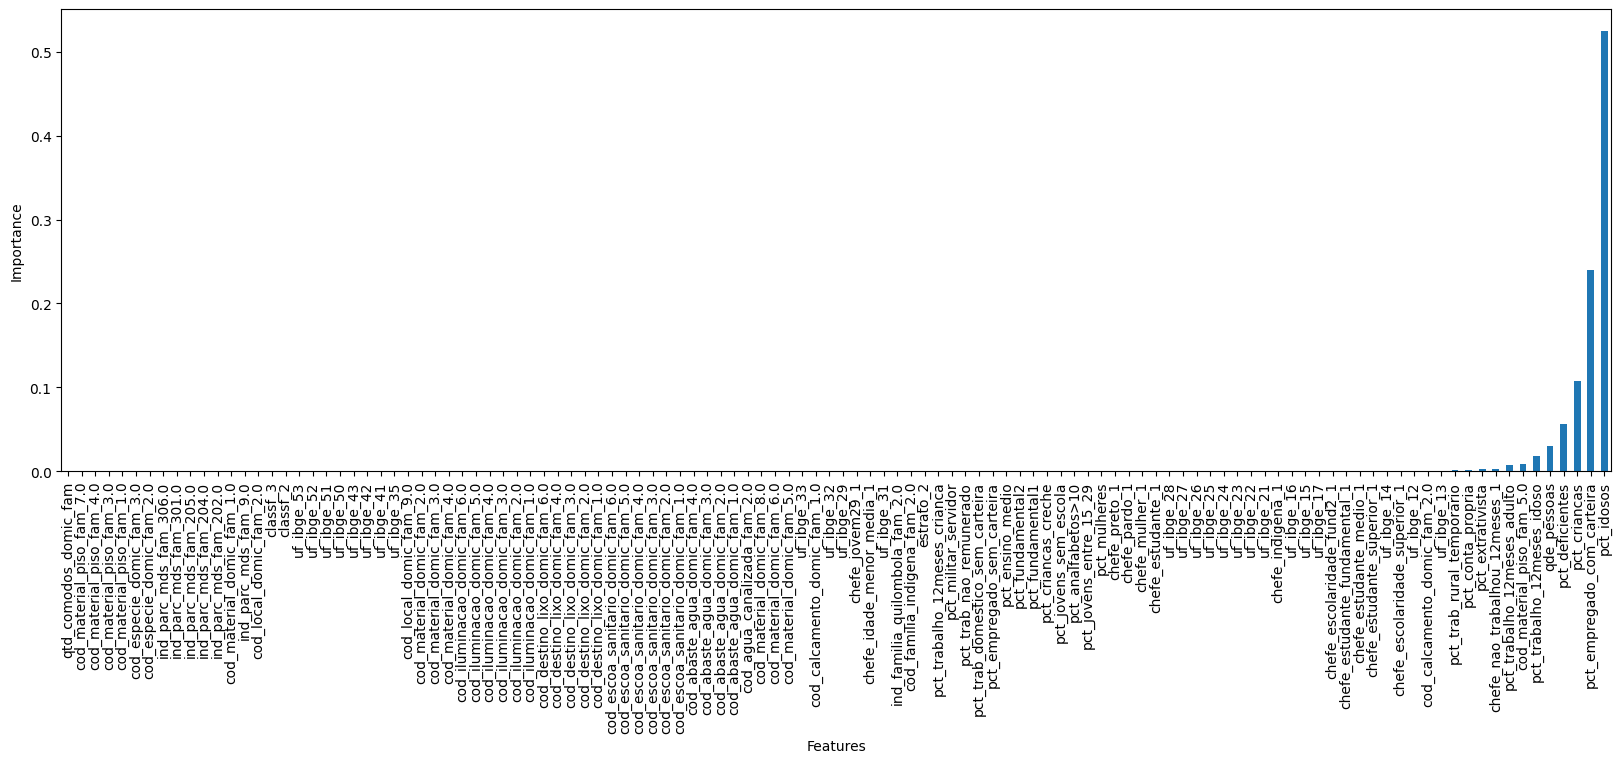

In [100]:
# importance of all features based of initial model

""" gráfico mostra a importância relativa de cada variável no modelo.
um valor maior indica que a feature tem um impacto mais significativo 
na previsão do modelo."""

sel.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

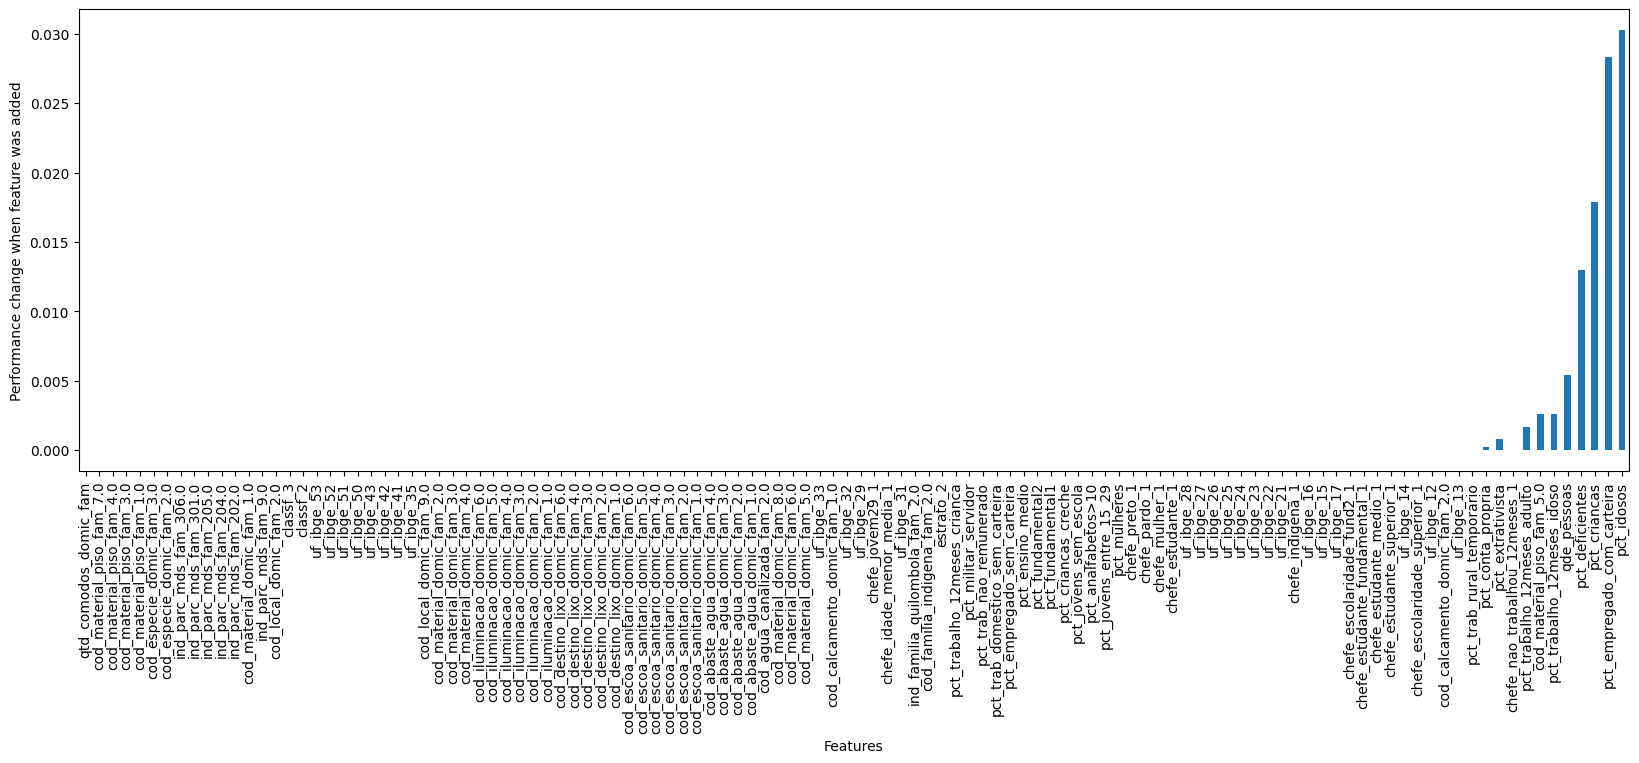

In [101]:
# mudança de performance do modelo quando uma feature é adicionada

"""o gráfico mostra a mudança de performance do modelo quando uma feature é adicionada.
um valor positivo indica que a feature tem um impacto positivo na previsão do modelo,
enquanto o valor negativo indica que a inclusão da feature pode degradar a performance 
do modelo."""

pd.Series(sel.performance_drifts_).plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

In [102]:
# Number of features that will be removed

print(f'Shape antes: {df_tratado.shape}')

print(f'Features removidas: {len(sel.features_to_drop_)}')

# select features

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train.shape, X_test.shape


Shape antes: (96502, 127)
Features removidas: 105


((67551, 9), (28951, 9))

In [103]:
X_train.columns

Index(['qde_pessoas', 'pct_criancas', 'pct_idosos', 'pct_deficientes',
       'pct_extrativista', 'pct_empregado_com_carteira',
       'pct_trabalho_12meses_adulto', 'pct_trabalho_12meses_idoso',
       'cod_material_piso_fam_5.0'],
      dtype='object')

In [104]:
from sklearn.metrics import roc_auc_score

# Fit the model with the selected features
model.fit(X_train, y_train)

# Make predictions
y_pred_test = model.predict_proba(X_test)

# Calculate ROC AUC for multi-class
roc_final = roc_auc_score(y_test, y_pred_test, multi_class='ovr')
print('Initial ROC AUC=%f' % (auc_inicial))
print('Test selected features ROC AUC=%f' % (roc_final))


Initial ROC AUC=0.843509
Test selected features ROC AUC=0.835434


In [106]:
# ANALISANDO MODELOS COM AS MELHORES COLUNAS
cols_use = ['classe_renda', 'qde_pessoas', 'pct_criancas', 'pct_idosos', 'pct_deficientes',
       'pct_extrativista', 'pct_empregado_com_carteira',
       'pct_trabalho_12meses_adulto', 'pct_trabalho_12meses_idoso',
       'cod_material_piso_fam_5.0']

# Deletar as colunas
df1 = df_tratado[cols_use]
df1

,classe_renda,qde_pessoas,pct_criancas,pct_idosos,pct_deficientes,pct_extrativista,pct_empregado_com_carteira,pct_trabalho_12meses_adulto,pct_trabalho_12meses_idoso,cod_material_piso_fam_5.0
0,0.0,0.250000,0.500000,0.0,0.0,0.250000,0.0,0.250000,0.0,1.0
1,0.0,0.083333,0.500000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0
2,2.0,0.083333,0.000000,0.0,0.0,0.000000,0.0,1.000000,0.0,1.0
3,0.0,0.083333,0.500000,0.0,0.0,0.000000,0.0,0.000000,0.0,1.0
4,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
96497,0.0,0.166667,0.666667,0.0,0.0,0.000000,0.0,0.333333,0.0,1.0
96498,0.0,0.083333,0.500000,0.0,0.0,0.000000,0.0,0.000000,0.0,1.0
96499,2.0,0.083333,0.000000,1.0,0.0,0.000000,0.0,0.000000,0.0,1.0
96500,0.0,0.166667,0.333333,0.0,0.0,0.333333,0.0,0.333333,0.0,1.0


In [107]:
# separate train and test sets
print(f'Shape df: {df1.shape}')

X_train, X_test, y_train, y_test = train_test_split(
    df1.drop(labels=['classe_renda'], axis=1),
    df1['classe_renda'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

Shape df: (96502, 10)


((67551, 9), (28951, 9))

In [108]:
# analisando modelos com as melhores colunas
df_resultados_smote = evaluate_models_with_smote(X_train, y_train, X_test, y_test)


Avaliando modelo: Random Forest
Scores de validação cruzada: [0.7091339  0.70989401 0.70828935 0.70410878 0.70768581]
Acurácia média de treino: 0.7078223697125191
Relatório de classificação:
              precision    recall  f1-score   support

         0.0       0.84      0.81      0.82     16905
         1.0       0.53      0.51      0.52      6176
         2.0       0.65      0.75      0.70      5870

    accuracy                           0.73     28951
   macro avg       0.67      0.69      0.68     28951
weighted avg       0.74      0.73      0.73     28951

Acurácia do Teste: 0.7325826396324825
Desempenho ROC/AUC: 0.8574352298765691
--------------------------------------------------
Avaliando modelo: XGBoost
Scores de validação cruzada: [0.70850049 0.71099193 0.70765593 0.7036865  0.70663007]
Acurácia média de treino: 0.7074929828137966
Relatório de classificação:
              precision    recall  f1-score   support

         0.0       0.84      0.82      0.83     16905
      